In [1]:
# This script loads the images from /Users/avesga/Code/radialsym and analyzes them with eSRRF3D
# test version to have everything working, later on we will use an automatic python script

# agv, 19Mar2023

import os

import matplotlib as mpl
import stackview
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from nanopyx.methods.esrrf_3d.run import run_esrrf3d

from scipy.signal import find_peaks

from nanopyx.core.transform._le_esrrf3d import eSRRF3D

In [2]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

In [3]:
# set parameters

path = "/Users/avesga/Code/radialsym/simulations/PLANES_num_planes_5_distance_emitters_1_px_size_0.02_int_f_3000_offset_200_int_noise_100.tiff"
path_full = "/Users/avesga/Code/radialsym/simulations/FULL_distance_emitters_1_px_size_0.02_int_f_3000_offset_200_int_noise_100.tiff"

# path = "/Users/avesga/Code/radialsym/simulations_below_500nm/PLANES_num_planes_5_distance_planes_[3, 3, 2]_distance_emitters_0.4_px_size_0.02_int_f_3000_offset_200_int_noise_100.tiff"
# path_full = "/Users/avesga/Code/radialsym/simulations_below_500nm/PLANES_num_planes_5_distance_planes_[3, 3, 2]_distance_emitters_0.4_px_size_0.02_int_f_3000_offset_200_int_noise_100.tiff"

# from the last part of the path, get the number of planes, the separation between planes, and the pixel size
last_part = os.path.basename(path).split('/')[-1]
print(last_part)

num_planes = int(last_part.split('num_planes_')[1].split('_')[0])
distance_emitters = float(last_part.split('distance_emitters_')[1].split('_')[0])

print(num_planes, distance_emitters)

pixel_size = 0.120
separation_planes = 4

PLANES_num_planes_5_distance_emitters_1_px_size_0.02_int_f_3000_offset_200_int_noise_100.tiff
5 1.0


In [4]:
# Load file

img = imread(path).astype(np.float32)
img_full = imread(path_full).astype(np.float32)

In [5]:
# Define variables for eSRRF

magnification_xy=2
magnification_z=2
radius=1
radius_z = 1
ratio_px = 4
sensitivity=1
run_type="Threaded"
correlation="AVG"
framewindow=0
rollingoverlap=2

In [6]:
# esrrf3d
esrrf = eSRRF3D()

rgc_img = run_esrrf3d(img, magnification_xy=magnification_xy, magnification_z=magnification_z, radius=radius, radius_z =radius_z, ratio_px = ratio_px, sensitivity=sensitivity, run_type=run_type, correlation=correlation, framewindow=framewindow, rollingoverlap=rollingoverlap)

rgc_img = rgc_img.squeeze()


Consider adding default arguments to the njit implementation to trigger early compilation
Consider adding default arguments to the njit implementation to trigger early compilation
Querying the Agent...
Agent: ShiftMagnify_CR using Threaded_guided ran in 0.002717999999999776 seconds
Consider adding default arguments to the njit implementation to trigger early compilation
Querying the Agent...
Agent: ShiftMagnify_CR using Threaded_guided ran in 0.0023541250000000957 seconds
Consider adding default arguments to the njit implementation to trigger early compilation
Unexpected error while trying to run Threaded
while scanning a simple key
  in "/Users/avesga/.nanopyx/liquid/_le_interpolation_catmull_rom.cpython-39-darwin/ShiftAndMagnify.yml", line 1510, column 1
could not find expected ':'
  in "/Users/avesga/.nanopyx/liquid/_le_interpolation_catmull_rom.cpython-39-darwin/ShiftAndMagnify.yml", line 1521, column 87
Please try again with another run type


AttributeError: 'NoneType' object has no attribute 'shape'

Text(0.5, 1.0, 'XZ intensity at the center')

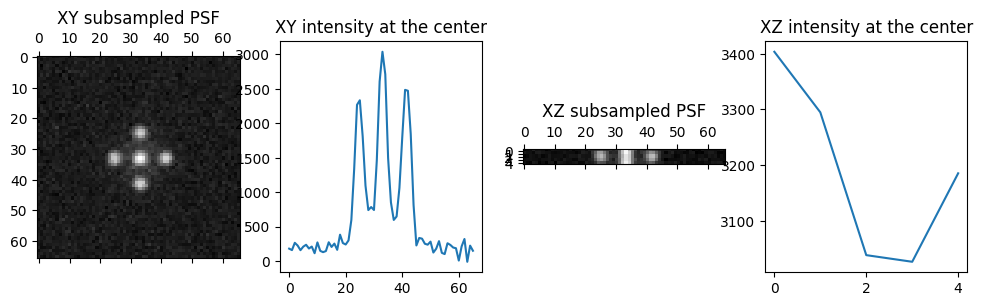

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

ax[0].matshow(img[img.shape[0]//2, :, : ])
ax[1].plot(img[img.shape[0]//2, img.shape[1]//2, : ])
ax[2].matshow(img[:,:, img.shape[2]//2])
ax[3].plot(img[:,img.shape[1]//2, img.shape[2]//2])

ax[0].set_title("XY subsampled PSF")
ax[1].set_title("XY intensity at the center")
ax[2].set_title("XZ subsampled PSF")
ax[3].set_title("XZ intensity at the center")

In [ ]:
def render_z(rgc_img, separation_planes, magnification_z):

    z_section = np.zeros((rgc_img.shape[1], rgc_img.shape[1], rgc_img.shape[1]))

    num_planes = rgc_img.shape[0] // magnification_z

    if num_planes % 2 == 1:
        planes = np.arange(num_planes) * separation_planes * magnification_z
        planes = planes + (rgc_img.shape[1]//2 - planes[planes.shape[0]//2])
    else:
        # check if separation_planes is even
        if separation_planes % 2 == 0:
            planes = np.arange(num_planes) * separation_planes * magnification_z
            planes = planes + (rgc_img.shape[1]//2 - planes[planes.shape[0]//2]) + 1*magnification_z*separation_planes
        else:
            # print a warning, saying that the planes are not evenly distributed
            print("Warning: the planes are not evenly distributed. Use even separation for even number of planes.")

    # TODO: check the shift of the planes, is almost perfect, but maybe not

    for p in range(num_planes):
        for m in range(magnification_z):
            z_section[planes[p]-m, :, :] = rgc_img[p*magnification_z+m, :, :]

    return z_section

In [ ]:
separation_planes = 4

rgc_img_Z = render_z(rgc_img, separation_planes, magnification_z)
img_Z = render_z(img, separation_planes, 1)

[2.04]
[]


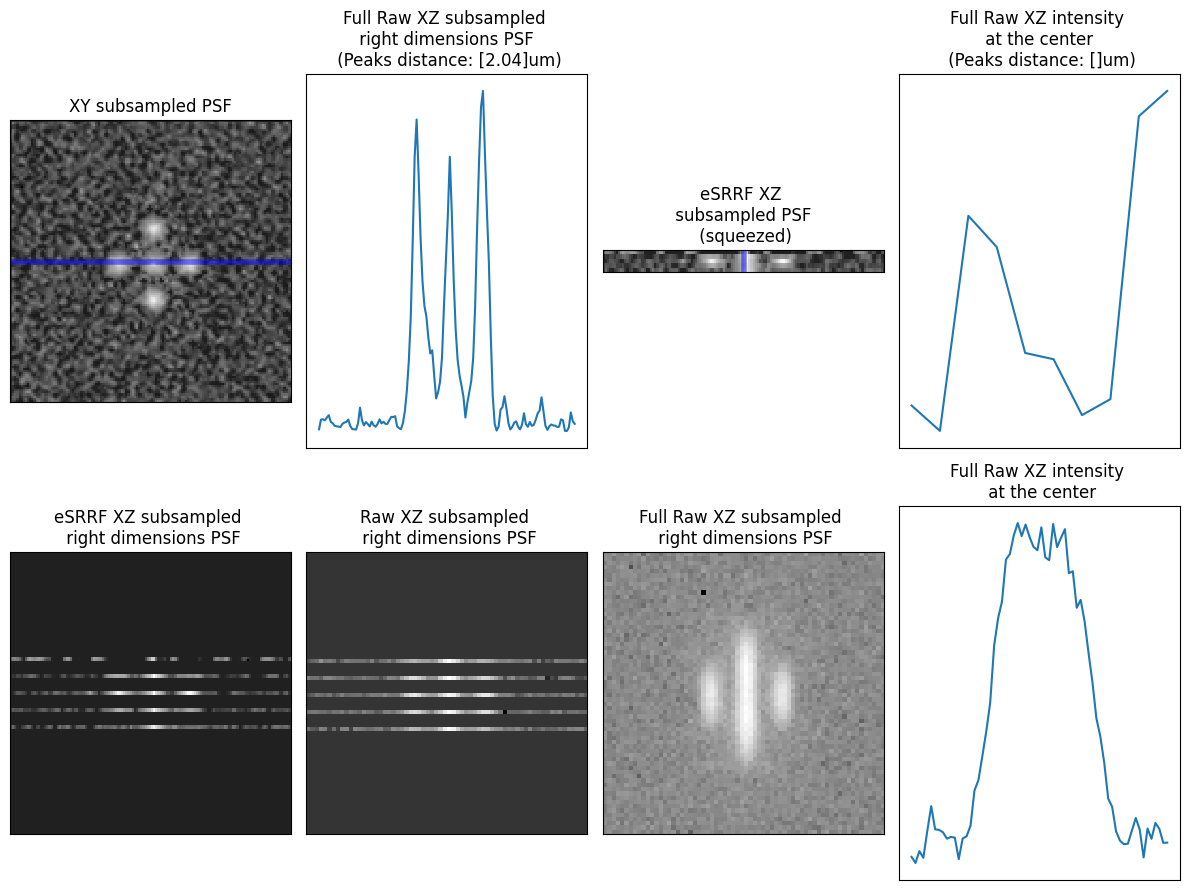

In [ ]:
# Plot the profiles

fig, ax = plt.subplots(2, 4, figsize=(12, 9))

gam = 0.3

ax[0,0].matshow(rgc_img[rgc_img.shape[0]//2, :, : ], norm=mpl.colors.PowerNorm(gam))
ax[0,0].axhline(rgc_img.shape[1]//2, color='blue', linewidth=4, alpha=0.5)

ax[0,1].plot(rgc_img[rgc_img.shape[0]//2, rgc_img.shape[1]//2, : ])

ax[0,2].matshow(rgc_img[:,:, rgc_img.shape[2]//2], norm=mpl.colors.PowerNorm(gam))
ax[0,2].axvline(rgc_img.shape[2]//2, color='blue', linewidth=4, alpha=0.5)

ax[0,3].plot(rgc_img[:,rgc_img.shape[1]//2, rgc_img.shape[2]//2])

ax[1,0].matshow(rgc_img_Z[:,:, rgc_img_Z.shape[2]//2], norm=mpl.colors.PowerNorm(gam))

ax[1,1].matshow(img_Z[:,:, img_Z.shape[2]//2], norm=mpl.colors.PowerNorm(gam))

ax[1,2].matshow(img_full[:,:, img_full.shape[2]//2], norm=mpl.colors.PowerNorm(gam))
ax[1,3].plot(img_full[:,img_full.shape[1]//2, img_full.shape[2]//2])

ax[0,0].set_title("XY subsampled PSF")

ax[0,2].set_title("eSRRF XZ \n subsampled PSF \n (squeezed)")

ax[1,0].set_title("eSRRF XZ subsampled \n right dimensions PSF")
ax[1,1].set_title("Raw XZ subsampled \n right dimensions PSF")
ax[1,2].set_title("Full Raw XZ subsampled \n right dimensions PSF")
ax[1,3].set_title("Full Raw XZ intensity \n at the center")

# get the distance between peaks in the first plot
peaks_indices_XY, _ = find_peaks(rgc_img[rgc_img.shape[0]//2, rgc_img.shape[1]//2, : ], height=0.5*rgc_img[rgc_img.shape[0]//2, :].max())
print((peaks_indices_XY[1:] - peaks_indices_XY[:-1])*pixel_size/magnification_xy)

# get the distance between peaks in the second plot
peaks_indices_XZ, _ = find_peaks(rgc_img[:,rgc_img.shape[1]//2, rgc_img.shape[2]//2], height=0.1*rgc_img[:, :].max())
print((peaks_indices_XZ[1:] - peaks_indices_XZ[:-1]) * pixel_size*separation_planes/magnification_z)

# write the distance between peaks the second and forth plot
ax[0,1].set_title("Full Raw XZ subsampled \n right dimensions PSF \n (Peaks distance: {}um)".format((peaks_indices_XY[1:] - peaks_indices_XY[:-1]) * pixel_size/magnification_z))
ax[0,3].set_title("Full Raw XZ intensity \n at the center \n (Peaks distance: {}um)".format((peaks_indices_XZ[1:] - peaks_indices_XZ[:-1]) * pixel_size*separation_planes/magnification_z))


# elliminate ticks
for a in ax:
    for b in a:
        b.set_xticks([])
        b.set_yticks([])

fig.tight_layout()
